In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
rating_df = pd.read_csv('../data/interim/rating_df.csv')
# rating_df = pd.read_csv('/kaggle/input/movielens/rating_df.csv')
rating_df.head()

,user_id,movie_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [3]:
train_df, val_df = train_test_split(rating_df, test_size=0.2, 
                                    stratify=rating_df['user_id'], random_state=42)

In [4]:
print(train_df.shape, val_df.shape)

(80000, 3) (20000, 3)


## DataLoader

In [5]:
from torch.utils.data import Dataset, DataLoader

class MovieDataset(Dataset):
    """
        MovieDataset class for handling user-item-rating data
    """
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        user_id, item_id, rating = self.df.iloc[idx]
        sample = {"user": user_id - 1, "item": item_id - 1, "rating": rating}
        return sample
    
train_loader = DataLoader(MovieDataset(train_df), batch_size=16, shuffle=True)
val_loader = DataLoader(MovieDataset(val_df), batch_size=16, shuffle=False,)

## Matrix Factorization Model

Reference: https://towardsdatascience.com/recommendation-system-matrix-factorization-d61978660b4b

This implementation defines a simple Matrix Factorization model using PyTorch. The model learns embeddings for users and items and predicts ratings by taking the dot product of the user and item embeddings.

In [6]:
import torch
import torch.nn as nn
from torch import optim

class MatrixFactorization(nn.Module):
    """
        MatrixFactorization model for collaborative filtering.

        Parameters:
        - num_users (int): Number of users in the user-item interaction matrix
        - num_items (int): Number of items in the user-item interaction matrix
        - embedding_dim (int): Dimensionality of the user and item embeddings

        Note:
        - sparse=True is used for embedding layers to handle sparse inputs efficiently
    """
    
    def __init__(self, num_users, num_items, embedding_dim=20):
        super(MatrixFactorization, self).__init__()
        self.user_embeddings = nn.Embedding(num_users, embedding_dim, sparse=True)
        self.item_embeddings = nn.Embedding(num_items, embedding_dim, sparse=True)

    def forward(self, user_input, item_input):
        """
            Forward pass of the model

            Parameters:
            - user_input (torch.Tensor): Input tensor representing user indices
            - item_input (torch.Tensor): Input tensor representing item indices

            Returns:
            - torch.Tensor: Predicted ratings
        """
        user_emb = self.user_embeddings(user_input)
        item_emb = self.item_embeddings(item_input)
        return torch.sum(user_emb * item_emb, dim=1)
    
num_user = 943
num_item = 1682

model = MatrixFactorization(num_user, num_item)

In [7]:
from tqdm import tqdm

train_losses = []  
valid_losses = []
    
def train(model, device, num_epochs, train_loader, valid_loader, loss_fn, optimizer):
    model.to(device)
    
    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(
            total=len(train_df), desc=f"Epoch {epoch}/{num_epochs}", unit="items"
        ) as pbar:
            for batch in train_loader:
                user = batch['user']
                item = batch['item']
                rating = batch['rating']
                
                user, item, rating = user.to(device), item.to(device), rating.to(device)
                optimizer.zero_grad()

                outputs = model(user, item)
                loss = loss_fn(outputs, rating.float())
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
                pbar.update(user.shape[0])
                pbar.set_postfix(**{"loss (batch)": loss.item()})
                
        average_train_loss = epoch_loss / len(train_loader)
        train_losses.append(average_train_loss)
        
        model.eval()
        
        with tqdm(total=len(val_df), desc=f"Validation", unit="items") as pbar:
            with torch.no_grad():
                for batch in val_loader:
                    user = batch['user']
                    item = batch['item']
                    rating = batch['rating']
                    user, item, rating = user.to(device), item.to(device), rating.to(device)

                    outputs = model(user, item)
                    loss = loss_fn(outputs, rating)
            
                    pbar.update(user.shape[0])
                    epoch_loss += loss.item()
                    pbar.set_postfix(**{"loss (batch)": loss.item()})
                    
        average_valid_loss = epoch_loss / len(valid_loader)
        valid_losses.append(average_valid_loss)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
num_epoch = 30
train(model, device, num_epoch, train_loader, val_loader, loss_fn, optimizer)

Validation: 100%|██████████| 20000/20000 [00:02<00:00, 6782.32items/s, loss (batch)=2.91] 


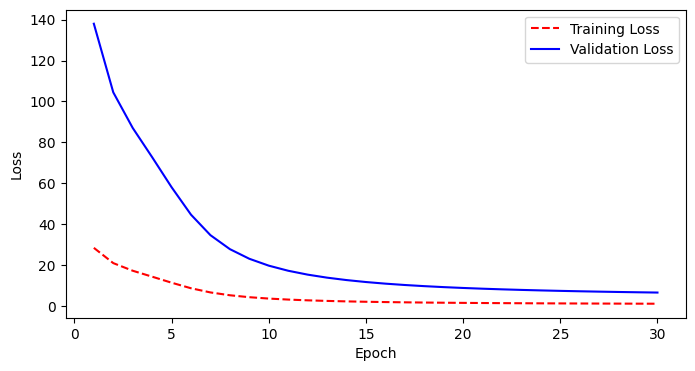

In [10]:
import matplotlib.pyplot as plt

# Plot training and validation losses over epochs
plt.figure(figsize = (8,4))
plt.plot(range(1, num_epoch + 1), train_losses, 'r--', label='Training Loss')
plt.plot(range(1, num_epoch + 1), valid_losses, 'b-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

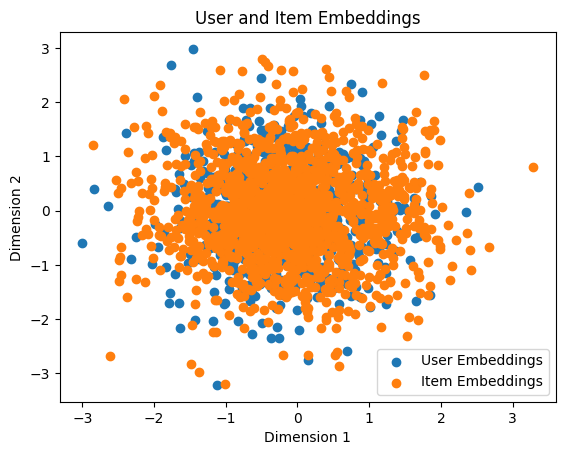

In [20]:
user_embeddings = model.user_embeddings.weight.cpu().detach().numpy()
item_embeddings = model.item_embeddings.weight.cpu().detach().numpy()

plt.scatter(user_embeddings[:, 0], user_embeddings[:, 1], label='User Embeddings')
plt.scatter(item_embeddings[:, 0], item_embeddings[:, 1], label='Item Embeddings')
plt.legend()
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('User and Item Embeddings')
plt.show()

In [11]:
torch.save(model.state_dict(), "matrix_factorixation.pt")

## Prediction

In [ ]:
# model = MatrixFactorization(num_user, num_item)
# model.load_state_dict(torch.load('/kaggle/working/matrix_factorixation.pt'))

In [12]:
# item_df = pd.read_csv('/kaggle/input/itemsmovie/item_df.csv')
item_df = pd.read_csv('../data/interim/item_df.csv')
item_df.head()

,movie_id,movie_title,release_date,unknown,action,adventure,animation,childrens,comedy,crime,...,fantasy,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [13]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   user_id   100000 non-null  int64
 1   movie_id  100000 non-null  int64
 2   rating    100000 non-null  int64
dtypes: int64(3)
memory usage: 2.3 MB


In [14]:
from sklearn.preprocessing import MinMaxScaler

def predict_rating(rec_df, rating_df):
    """
        Predict ratings for movies in rec_df using the model

        Parameters:
        - rec_df (DataFrame): DataFrame containing user_id and movie_id pairs for which to predict ratings
        - rating_df (DataFrame): DataFrame containing historical user-item ratings

        Returns:
        - rec_df (DataFrame): DataFrame with predicted ratings added
        - preds (numpy array): Array of predicted ratings
    """
    
    model.eval()
    dataloader = DataLoader(MovieDataset(rec_df), batch_size=16, shuffle=False,)
    pbar = tqdm(dataloader, total=len(dataloader))
    preds = []
    for data in pbar:
        user = data['user']
        item = data['item']
        rating = data['rating']
        user, item, rating = user.to(device), item.to(device), rating.to(device)

        with torch.no_grad():
            preds.append(model(user, item))

    preds = torch.cat(preds).cpu().detach().numpy()
    movie_ids = rec_df['movie_id'].unique()
    
    # Calculate average ratings for movies in rec_df
    avg_ratings = rating_df[rating_df['movie_id'].isin(movie_ids)].groupby('movie_id')['rating'].mean()
    scaler = MinMaxScaler(feature_range=(1, 5)) # Scale average ratings to range (1, 5)
    avg_ratings = scaler.fit_transform(avg_ratings.values.reshape(-1, 1))
    avg_ratings = avg_ratings.flatten()

    rec_df['rating'] = rec_df['movie_id'].map(dict(zip(movie_ids, avg_ratings))).fillna(0)
    return rec_df, preds


def recommend_for_user(user_id, rating_df, item_df, top_n=10):
    """
        Provide movie recommendations for a given user

        Parameters:
        - user_id (int): User for whom recommendations are requested
        - rating_df (DataFrame): DataFrame containing historical user-item ratings
        - item_df (DataFrame): DataFrame containing information about movies
        - top_n (int): Number of top recommendations to display

        Returns:
        - None: Prints the top recommended movies and movies already watched by the user
    """
    
    rec_df = rating_df.query("user_id != @user_id")
    rec_df['user_id'] = user_id
    rec_df = rec_df.drop_duplicates(subset=['user_id', 'movie_id'])

    rec_df, preds = predict_rating(rec_df, rating_df)

    d = dict(zip(item_df.movie_id, item_df.movie_title))
    rec_df['title'] = rec_df['movie_id'].map(d)
    rec_df['rating'] = preds
    rec_df['rating'] = preds.clip(1, 5)
    rec_df = rec_df.sort_values('rating', ascending=False)

    #  Print top_n recommended movies with their ratings
    print('\nRECOMMENDATIONS')
    print(rec_df[['title','rating']].head(top_n))

    user_df = rating_df.query("user_id == @user_id")
    user_df['title'] = user_df['movie_id'].map(d)
    user_df = user_df.sort_values('rating', ascending=False)

    # Print top_n movies already watched by the user with their ratings
    print('\nWHAT ALREADY WATCHED')
    print(user_df[['title','rating']].head(top_n))

In [18]:
import random

user_id = random.choice(rating_df.user_id.values)
print(user_id)

recommend_for_user(user_id, rating_df, item_df)

417


100%|██████████| 106/106 [00:00<00:00, 879.62it/s]


RECOMMENDATIONS
                              title    rating
33169           Legal Deceit (1997)  5.000000
924          Shall We Dance? (1996)  4.811883
794            Roman Holiday (1953)  4.801003
372      Wrong Trousers, The (1993)  4.754656
2923        Daytrippers, The (1996)  4.717150
1498          Paths of Glory (1957)  4.712457
37535      Naked in New York (1994)  4.683064
145        Good Will Hunting (1997)  4.632608
1565   Cat on a Hot Tin Roof (1958)  4.615756
26400              Hugo Pool (1997)  4.603000

WHAT ALREADY WATCHED
                                                 title  rating
46515                                   Aladdin (1992)       5
49929  Cook the Thief His Wife & Her Lover, The (1989)       5
61879                          Boys on the Side (1995)       5
22384                      Hudsucker Proxy, The (1994)       5
60034                                Phenomenon (1996)       5
32536                         Miller's Crossing (1990)       5
33676         

## Evaluation 

To evaluate the model, I chose a leave-one-out cross-validation approach. For each user, we excluded one movie at a time from their watched list and predicted its rating. Then I calculate average MSE

In [85]:
from sklearn.metrics import mean_squared_error, precision_score, recall_score
import numpy as np

def predict_rating_for_user(model, user_id, watched_movies, target_movie_id, device):
    """
        Predict the rating for a target movie given the user's watched movies.

        Parameters:
        - model: Trained model
        - user_id: User ID for whom to make the prediction
        - watched_movies: List of movie IDs that the user has already watched
        - target_movie_id: Movie ID for which to predict the rating
        - device: CPU or GPU

        Returns:
        - prediction: Predicted rating for the target movie
    """
    model.eval()
    user_input = torch.tensor([user_id - 1], dtype=torch.long).to(device)
    watched_movie_input = torch.tensor([movie_id - 1 for movie_id in watched_movies], dtype=torch.long).to(device)
    target_movie_input = torch.tensor([target_movie_id - 1], dtype=torch.long).to(device)

    # Extract embeddings for the user and movies
    user_embedding = model.user_embeddings(user_input)
    watched_movie_embeddings = model.item_embeddings(watched_movie_input)
    target_movie_embedding = model.item_embeddings(target_movie_input)

    # Compute the dot product of user and target movie embeddings
    prediction = torch.sum(user_embedding * target_movie_embedding)
    
    return prediction.item()


true_labels = []
predicted_scores = []
unique_user_ids = rating_df['user_id'].unique()

for user_id in tqdm(unique_user_ids, desc="Users", unit="user"):
    user_df = rating_df[rating_df['user_id'] == user_id].copy()

    for index, row in user_df.iterrows():
        movie_id = row['movie_id']
        user_df_excluded = user_df[user_df['movie_id'] != movie_id]

        pred_rating = predict_rating_for_user(model, user_id, np.array(user_df_excluded['movie_id']), movie_id, device)
        true_rating = row['rating']
        
        true_labels.append(true_rating)
        predicted_scores.append(pred_rating)

ratings_array = [max(1, min(round(pred), 5)) for pred in predicted_scores]
mse = mean_squared_error(true_labels, ratings_array)

print(f"MSE: {mse}")

Users: 100%|██████████| 943/943 [01:38<00:00,  9.56user/s]

MSE: 1.1689


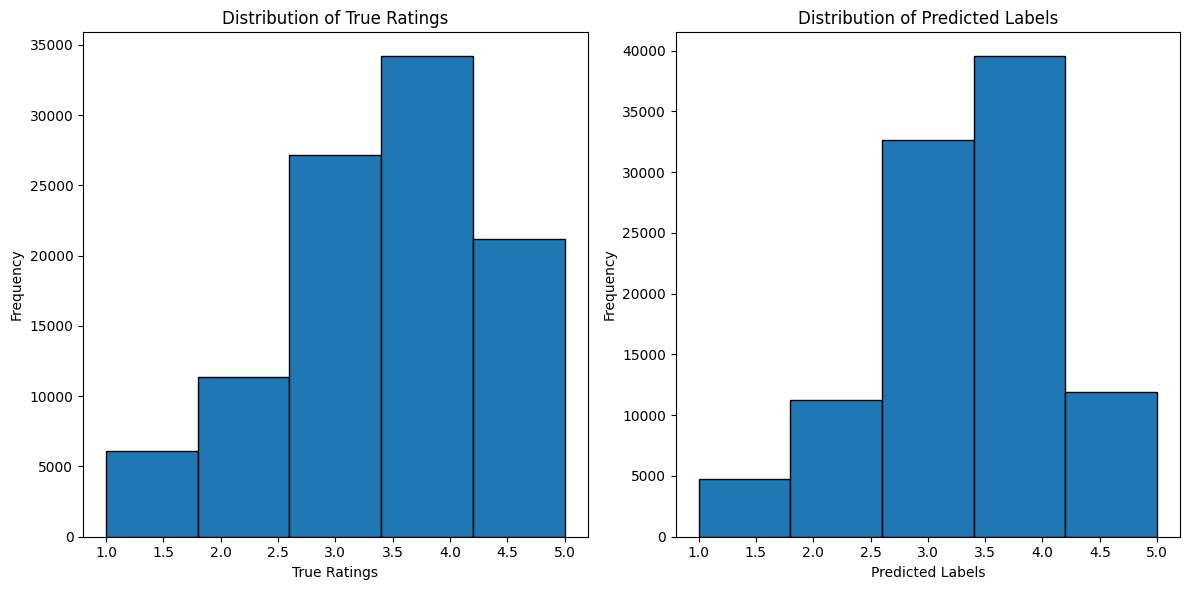

In [86]:
plt.figure(figsize=(12, 6))

# Distribution of true ratings
plt.subplot(1, 2, 1)
plt.hist(true_labels, bins=5, edgecolor='black')
plt.title('Distribution of True Ratings')
plt.xlabel('True Ratings')
plt.ylabel('Frequency')

# Distribution of predicted labels
plt.subplot(1, 2, 2)
plt.hist(ratings_array, bins=5, edgecolor='black')
plt.title('Distribution of Predicted Ratings')
plt.xlabel('Predicted Ratings')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()